In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import Trainer, TrainingArguments,AutoTokenizer,AutoModelForSequenceClassification
import torch

class ComprehensiveComparison:
    def __init__(self):
        """Initialize storage for models and results."""
        self.models = {}
        self.results = {}

    def load_all_models(self,
                        week1_preprocessor,  # VADER
                        week2_feature_extractor,  # TF-IDF
                        week2_lr_model,
                        week2_nb_model,
                        week2_knn_model,
                        finbert_model):  # Fine-tuned FinBERT
        """Load all trained models."""
        self.models['VADER'] = week1_preprocessor
        self.models['TF-IDF + LogisticRegression'] = (week2_feature_extractor, week2_lr_model)
        self.models['TF-IDF + NaiveBayes'] = (week2_feature_extractor, week2_nb_model)
        self.models['TF-IDF + KNN'] = (week2_feature_extractor, week2_knn_model)
        self.models['FinBERT'] = finbert_model
        self.models["FinBERT_tokenizer"] = AutoTokenizer.from_pretrained("ProsusAI/finbert")

    # ---------------- Prediction helpers ---------------- #
    def _predict_vader(self, texts):
        """Use VADER preprocessor to get predictions."""
        score = [self.models['VADER'].polarity_scores(t)['compound'] for t in texts] #returning scores
        res=[1 if s>=0.05 else 0 if s<=-0.05 else 2 for s in score]
        #print(res)
        return res

    def _predict_tfidf_model(self, texts, model_key):
        """Use TF-IDF feature extractor + ML model."""
        vectorizer, model = self.models[model_key]
        X_vect = vectorizer.transform(texts)
        return model.predict(X_vect)

    def decode(self,x):
        if x==0:
          return 1
        elif x==1:
          return 0
        else:
          return 2
    def _predict_finbert(self, texts, model, batch_size=32):
      """Fast FinBERT batch predictions"""

      device = torch.device('cuda')

      tokenizer = self.models["FinBERT_tokenizer"]  # load once
      model = model.to(device)
      model.eval()

      preds = []

      with torch.no_grad():
          for i in range(0, len(texts), batch_size):
              batch_texts = texts[i:i+batch_size]

              inputs = tokenizer(
                  batch_texts,
                  return_tensors="pt",
                  truncation=True,
                  padding=True,
                  max_length=512
              )

              inputs = {k: v.to(device) for k, v in inputs.items()}

              outputs = model(**inputs)
              batch_preds = torch.argmax(outputs.logits, dim=1)

              preds.extend(batch_preds.cpu().numpy())
          preds=[self.decode(x) for x in preds]

      return np.array(preds)


    # ---------------- Metrics helper ---------------- #
    def _calculate_metrics(self, y_true, y_pred):
        return {
            "accuracy": accuracy_score(y_true, y_pred),
            "precision": precision_score(y_true, y_pred, average="weighted", zero_division=0),
            "recall": recall_score(y_true, y_pred, average="weighted", zero_division=0),
            "f1": f1_score(y_true, y_pred, average="weighted", zero_division=0)
        }

    # ---------------- Evaluation ---------------- #
    def evaluate_all_models(self, X_test, y_test):
        """Evaluate all models on same test set."""
        results = {}
        confusion_matrices = {}

        # VADER
        vader_preds = self._predict_vader(X_test)
        results['VADER'] = self._calculate_metrics(y_test, vader_preds)
        confusion_matrices['VADER'] = confusion_matrix(y_test, vader_preds)
        print('vader done')

        # Logistic Regression
        lr_preds = self._predict_tfidf_model(X_test, 'TF-IDF + LogisticRegression')
        results['Logistic Regression'] = self._calculate_metrics(y_test, lr_preds)
        confusion_matrices['Logistic Regression'] = confusion_matrix(y_test, lr_preds)
        print('lr done')
        # Naive Bayes
        nb_preds = self._predict_tfidf_model(X_test, 'TF-IDF + NaiveBayes')
        results['Naive Bayes'] = self._calculate_metrics(y_test, nb_preds)
        confusion_matrices['Naive Bayes'] = confusion_matrix(y_test, nb_preds)
        print('bayes done')
        # KNN
        knn_preds = self._predict_tfidf_model(X_test, 'TF-IDF + KNN')
        results['KNN'] = self._calculate_metrics(y_test, knn_preds)
        confusion_matrices['KNN'] = confusion_matrix(y_test, knn_preds)
        print('knn done')
        # FinBERT
        finbert_preds = self._predict_finbert(X_test,self.models['FinBERT'])
        results['FinBERT'] = self._calculate_metrics(y_test, finbert_preds)
        confusion_matrices['FinBERT'] = confusion_matrix(y_test, finbert_preds)
        print('finbert done')

        self.results = results
        self.confusion_matrices = confusion_matrices
        return results

    # ---------------- Visualization ---------------- #
    def compare_and_visualize(self):
        """Create comparison tables and plots for all models."""
        comparison_df = pd.DataFrame(self.results).T

        # Accuracy & F1 bar plots
        plt.figure(figsize=(12, 5))
        comparison_df[['accuracy', 'f1']].plot(kind='bar')
        plt.title("Accuracy and F1 Comparison")
        plt.ylabel("Score")
        plt.xticks(rotation=45)
        plt.show()

        # Confusion matrices heatmaps
        for model_name, cm in self.confusion_matrices.items():
            plt.figure(figsize=(5,4))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['pos','neg','neu'], yticklabels=['pos','neg','neu'])
            plt.title(f"Confusion Matrix: {model_name}")
            plt.xlabel("Predicted")
            plt.ylabel("Actual")
            plt.show()

        return comparison_df

    # ---------------- Trade-off Analysis ---------------- #
    def trade_off_analysis(self):
        """Analyze accuracy vs speed vs complexity."""
        speeds = {
            'VADER': '<1ms',
            'Logistic Regression': '<1ms',
            'Naive Bayes': '<1ms',
            'KNN': '10ms',
            'FinBERT': '100ms'
        }

        complexity = {
            'VADER': 'Simple (lexicon)',
            'Logistic Regression': 'Medium (ML)',
            'Naive Bayes': 'Medium (ML)',
            'KNN': 'Medium-High (ML)',
            'FinBERT': 'High (transformers)'
        }

        # Accuracy for trade-off table
        accuracy = {k: v['accuracy'] for k,v in self.results.items()}

        trade_off_df = pd.DataFrame({
            'Accuracy': accuracy,
            'Speed': speeds,
            'Complexity': complexity
        }).sort_values('Accuracy', ascending=False)

        print("----- Trade-off Table -----")
        display(trade_off_df)


In [ ]:
!wget "https://raw.githubusercontent.com/Dhruba34/Data-Science-projects/refs/heads/main/assignments%20%26%20project/week%201/sentiment.py"
!wget "https://raw.githubusercontent.com/Dhruba34/Data-Science-projects/refs/heads/main/assignments%20%26%20project/week%201/pipeline.py"

--2026-01-06 05:28:38--  https://raw.githubusercontent.com/Dhruba34/Data-Science-projects/refs/heads/main/assignments%20%26%20project/week%201/sentiment.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2423 (2.4K) [text/plain]
Saving to: ‘sentiment.py.3’

sentiment.py.3      100%[===================>]   2.37K  --.-KB/s    in 0s      

2026-01-06 05:28:38 (39.4 MB/s) - ‘sentiment.py.3’ saved [2423/2423]

--2026-01-06 05:28:38--  https://raw.githubusercontent.com/Dhruba34/Data-Science-projects/refs/heads/main/assignments%20%26%20project/week%201/pipeline.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.13

In [ ]:
!pip install vaderSentiment

In [ ]:
!pip install textblob

In [ ]:
!pip install contractions

In [ ]:
import sentiment

In [ ]:
!wget "https://raw.githubusercontent.com/Dhruba34/Data-Science-projects/main/assignments%20%26%20project/week%202/knn.pkl"
!wget "https://raw.githubusercontent.com/Dhruba34/Data-Science-projects/main/assignments%20%26%20project/week%202/lr.pkl"
!wget "https://raw.githubusercontent.com/Dhruba34/Data-Science-projects/main/assignments%20%26%20project/week%202/nb.pkl"
!wget "https://raw.githubusercontent.com/Dhruba34/Data-Science-projects/main/assignments%20%26%20project/week%202/vector.pkl"

--2026-01-06 05:29:08--  https://raw.githubusercontent.com/Dhruba34/Data-Science-projects/main/assignments%20%26%20project/week%202/knn.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 741012 (724K) [application/octet-stream]
Saving to: ‘knn.pkl.3’

knn.pkl.3           100%[===================>] 723.64K  --.-KB/s    in 0.03s   

2026-01-06 05:29:09 (23.4 MB/s) - ‘knn.pkl.3’ saved [741012/741012]

--2026-01-06 05:29:09--  https://raw.githubusercontent.com/Dhruba34/Data-Science-projects/main/assignments%20%26%20project/week%202/lr.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
H

In [ ]:

from google.colab import drive
import joblib

drive.mount('/content/drive')
finbert=joblib.load('/content/drive/MyDrive/models/finbert.pkl')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
knn=joblib.load('knn.pkl')
lr=joblib.load('lr.pkl')
nb=joblib.load('nb.pkl')
vectorizer=joblib.load('vector.pkl')
vader=SentimentIntensityAnalyzer()

In [ ]:
obj=ComprehensiveComparison()
obj.load_all_models(vader,  # VADER
                        vectorizer,  # TF-IDF
                        lr,
                        nb,
                        knn,
                        finbert)


In [ ]:
!wget "https://raw.githubusercontent.com/Dhruba34/Data-Science-projects/main/assignments%20%26%20project/week%202/all-data.csv"

--2026-01-06 05:29:16--  https://raw.githubusercontent.com/Dhruba34/Data-Science-projects/main/assignments%20%26%20project/week%202/all-data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 672006 (656K) [application/octet-stream]
Saving to: ‘all-data.csv.1’

all-data.csv.1      100%[===================>] 656.26K  --.-KB/s    in 0.02s   

2026-01-06 05:29:16 (26.7 MB/s) - ‘all-data.csv.1’ saved [672006/672006]



In [ ]:
import pandas as pd
data=pd.read_csv("all-data.csv",encoding_errors='ignore',names=['sentiment','feedback'])

vader done
lr done
bayes done
knn done
finbert done


<Figure size 1200x500 with 0 Axes>

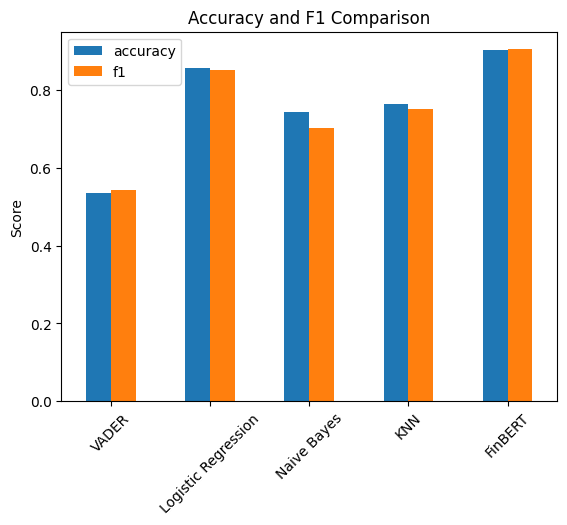

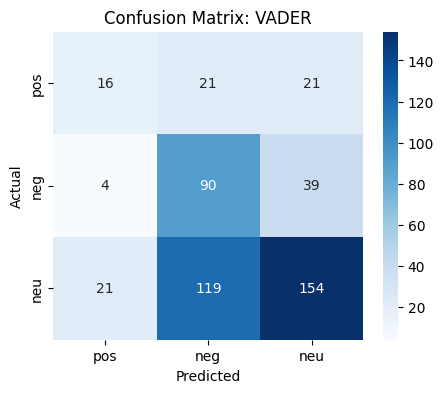

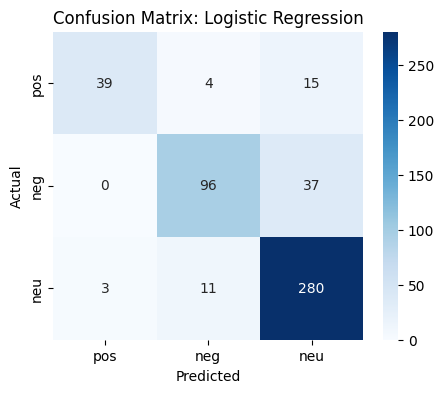

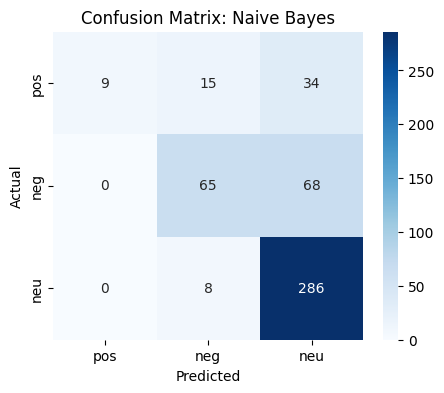

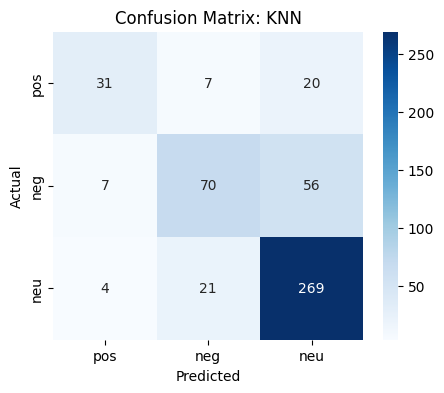

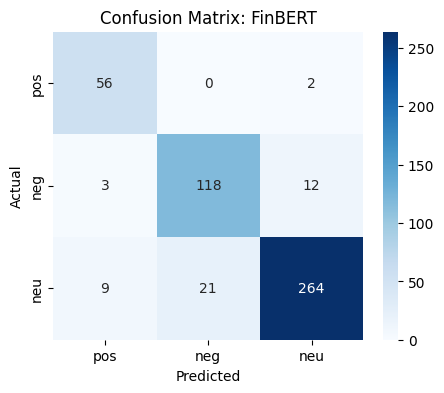

                     accuracy  precision    recall        f1
VADER                0.536082   0.590201  0.536082  0.542165
Logistic Regression  0.855670   0.859456  0.855670  0.851338
Naive Bayes          0.742268   0.768969  0.742268  0.701852
KNN                  0.762887   0.756792  0.762887  0.750715
FinBERT              0.903093   0.906939  0.903093  0.903788


----- Trade-off Table -----


,Accuracy,Speed,Complexity
FinBERT,0.903093,100ms,High (transformers)
Logistic Regression,0.855670,<1ms,Medium (ML)
KNN,0.762887,10ms,Medium-High (ML)
Naive Bayes,0.742268,<1ms,Medium (ML)
VADER,0.536082,<1ms,Simple (lexicon)


In [ ]:
from sklearn.model_selection import train_test_split
def decode_data(x):
  if x=='positive':
    return 1
  elif x=='neutral':
    return 2
  else:
    return 0
data['y']=data['sentiment'].apply(decode_data)
x=data['feedback'].tolist()
y=data['y'].tolist()
x1,x,y1,y=train_test_split(x,y,test_size=0.1, shuffle=True)
obj.evaluate_all_models(x,y)
df=obj.compare_and_visualize()
print(df.head())
print('\n')
obj.trade_off_analysis()